# Time series prediction
## Kitchen sink regression
In this notebook we are going to explore the performance of a simple ridge regressor on a time series
### Reading the data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(2018)

full_data =pd.read_csv('data/EightSeries.csv', parse_dates=['timestamp'], index_col='timestamp')
data = full_data.truncate(before='2011')


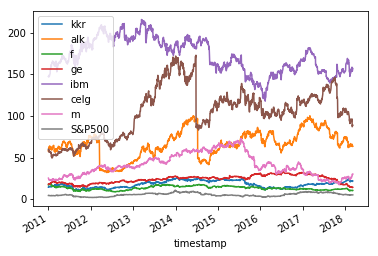

In [2]:
data.plot();

### Data preprocessing

In [3]:
data.tail()

,kkr,alk,f,ge,ibm,celg,m,S&P500
timestamp,,,,,,,,
2018-02-27,21.54,64.89,10.61,14.50,156.55,95.78,28.40,5.25
2018-02-28,21.46,64.50,10.61,14.11,155.83,87.12,29.41,5.19
2018-03-01,21.43,64.65,10.29,14.02,153.81,87.19,29.25,5.25
2018-03-02,21.56,63.38,10.40,14.12,154.49,89.33,30.41,5.29
2018-03-05,21.98,63.62,10.58,14.42,156.95,89.04,30.35,5.38


In [4]:
def transform_data(data, ref_col=None, offset=0):
    number_of_rows, _ = data.shape
    reference_day = number_of_rows-1-offset
    reference_day_values = data.iloc[reference_day, :]
    data_transformed = data.sub(reference_day_values, axis='columns')
    data_transformed = data_transformed.div(data) * 100
    if ref_col is not None:
        reference_column = data_transformed.loc[:, ref_col]
        data_transformed = data_transformed.sub(reference_column, axis='rows')
    return data_transformed

In [5]:
example_data = pd.DataFrame({'A': range(1, 6), 'B': range(6, 1, -1) , 'C': range(31, 36)})
result_1 = transform_data(example_data, ref_col=None, offset=1)
expected_1 = pd.DataFrame({'A': [-300.0, -100.0, -33.333333, 0.0, 20.0],
                         'B': [50.0, 40.0, 25.0, 0.0, -50.0],
                         'C': [-9.677419, -6.250000, -3.030303, 0.000000, 2.857143]})

result_2 = transform_data(example_data, ref_col='A', offset=2)
expected_2 = pd.DataFrame({'A': [0, 0, 0, 0, 0],
                           'B': [233.333333, 70.0, 0.0, -58.333333, -140.000000],
                           'C': [193.548387, 46.875000, 0.000000, -22.058824, -34.285714]})

from numpy.testing import assert_array_almost_equal
print( assert_array_almost_equal(result_1, expected_1) is None)
print( assert_array_almost_equal(result_2, expected_2) is None)

True
True


In [6]:
result_2

,A,B,C
0,0.0,233.333333,193.548387
1,0.0,70.000000,46.875000
2,0.0,0.000000,0.000000
3,0.0,-58.333333,-22.058824
4,0.0,-140.000000,-34.285714


In [7]:
transform_data(data.iloc[100:112 , :], ref_col=None, offset=5)

,kkr,alk,f,ge,ibm,celg,m,S&P500
timestamp,,,,,,,,
2011-05-26,3.647059,6.165503,4.464286,4.943357,1.453523,1.681803,5.933682,5.245347
2011-05-27,4.322430,6.332493,4.726027,5.041152,1.641791,2.371409,6.779661,4.273504
2011-05-31,4.712042,6.485046,6.769437,6.008147,2.474398,4.022328,6.682825,4.273504
2011-06-01,4.767442,3.601954,2.248770,3.502352,1.086695,2.420297,4.702970,3.945111
2011-06-02,5.098494,3.836784,1.904090,3.300157,0.806791,2.306150,3.818701,5.564924
2011-06-03,3.191489,1.235340,0.713776,1.912859,0.181763,0.679579,2.142338,1.234568
2011-06-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-07,-0.552486,0.863287,0.286738,0.108225,-0.647566,1.399899,2.987761,-2.003643
2011-06-08,-3.474416,-1.380417,-1.532847,0.270124,-0.249483,1.449764,3.127247,-4.868914


In [8]:
transform_data(data.iloc[100:112 , :], ref_col='S&P500', offset=5)

,kkr,alk,f,ge,ibm,celg,m,S&P500
timestamp,,,,,,,,
2011-05-26,-1.598288,0.920156,-0.781061,-0.301990,-3.791824,-3.563544,0.688336,0.0
2011-05-27,0.048926,2.058989,0.452523,0.767648,-2.631713,-1.902095,2.506157,0.0
2011-05-31,0.438538,2.211542,2.495933,1.734642,-1.799107,-0.251176,2.409321,0.0
2011-06-01,0.822330,-0.343158,-1.696341,-0.442759,-2.858416,-1.524814,0.757859,0.0
2011-06-02,-0.466430,-1.728140,-3.660834,-2.264767,-4.758133,-3.258774,-1.746223,0.0
2011-06-03,1.956921,0.000772,-0.520792,0.678291,-1.052805,-0.554989,0.907771,0.0
2011-06-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2011-06-07,1.451157,2.866930,2.290381,2.111868,1.356077,3.403542,4.991404,0.0
2011-06-08,1.394498,3.488497,3.336067,5.139038,4.619431,6.318678,7.996160,0.0


### Preserving some data for eventual validation

In [9]:
train_data = data.truncate(after='2015-12-31')
test_data  = data.truncate(before='2016-01-01')

print("train data from:{}, to:{}. Test data from:{}, to:{}".format(train_data.index.min(),
                                                                   train_data.index.max(),
                                                                   test_data.index.min(),
                                                                   test_data.index.max()))

train data from:2011-01-03 00:00:00, to:2015-12-31 00:00:00. Test data from:2016-01-04 00:00:00, to:2018-03-05 00:00:00


### Generating data lists

In [10]:
def transform_slice(data, at, window, ref_col=None, offset=None):
    number_of_rows, _ = data.shape
    left  = at
    right =  left + window + offset
    
    if (left > number_of_rows) or (right > number_of_rows):
        raise ValueError("wrong at, window or offset parameters")
        
    slice_of_data = data.iloc[left:right, :]
    result = transform_data(slice_of_data, ref_col=ref_col, offset=offset)
    result_X = result.iloc[:-offset-1, ] if offset > 0 else result.iloc[:-1, ]
    result_y = result.iloc[[-1], :]
    return result_X, result_y

In [11]:
transform_slice(example_data, at=1, window=3, offset=0)[0]


,A,B,C
1,-100.000000,40.0,-6.250000
2,-33.333333,25.0,-3.030303


In [12]:
def get_slices(data, window, ref_col, offset):
    number_of_rows, _ = data.shape
    slice_list = [transform_slice(data, at=pos, window=window, ref_col=ref_col, offset=offset)
                  for pos in range(0, number_of_rows-window-offset+1)]
    X_list = [ x for x, y in slice_list] 
    y_list = [ y for x, y in slice_list] 
    Xy_keys = [item.index[-1] for item in X_list]
    
    X_list = [ x.reset_index(drop=True) for x, y in slice_list] 
    y_list = [ y.reset_index(drop=True) for x, y in slice_list] 
    X = pd.concat(X_list, keys= Xy_keys)
    y = pd.concat(y_list, keys= Xy_keys)
    return X, y

In [13]:
X, y= get_slices(example_data, window=3, ref_col=None, offset=1)

In [14]:
X

A          B         C
1 0 -200.000000  33.333333 -6.451613
  1  -50.000000  20.000000 -3.125000
2 0 -100.000000  40.000000 -6.250000
  1  -33.333333  25.000000 -3.030303

In [15]:
X.head(20)

A          B         C
1 0 -200.000000  33.333333 -6.451613
  1  -50.000000  20.000000 -3.125000
2 0 -100.000000  40.000000 -6.250000
  1  -33.333333  25.000000 -3.030303

In [16]:
y.head(20)

,,A,B,C
1,0,25.0,-33.333333,2.941176
2,0,20.0,-50.000000,2.857143


We apply the transformer and obtain the data for regression

In [17]:
window_size = 220

In [18]:
X_train, y_train = get_slices(train_data, window=window_size, offset=5, ref_col='S&P500')
X_test, y_test   = get_slices(test_data,  window=window_size, offset=5, ref_col='S&P500')

In [19]:
print('X shape: ', X_train.shape)
print('y shape: ', y_train.shape)
print('='*80)
print('X head:\n' + '='*80 + '\n', X_train.head(10))
print('='*80)
print('y head:\n' + '='*80 + '\n', y_train.head(10))

X shape:  (226446, 8)
y shape:  (1034, 8)
X head:
                     kkr        alk         f         ge        ibm       celg  \
2011-11-11 0 -28.240538 -52.359381 -0.469424 -24.659764 -63.619540 -44.915922   
           1 -27.702655 -52.452163  0.863449 -22.242965 -62.626842 -46.515820   
           2 -25.875951 -51.460151  0.306103 -24.468629 -65.500882 -47.574948   
           3 -25.756607 -50.739180  1.022391 -25.240313 -64.520454 -48.716695   
           4 -27.666444 -45.728812  0.793651 -26.246458 -65.536628 -48.794230   
           5 -25.626156 -44.004148  2.259724 -24.534596 -64.451090 -52.756570   
           6 -23.600000 -42.715801  4.715536 -21.419753 -62.206681 -47.103448   
           7 -22.466709 -41.327079  5.953623 -21.381993 -60.801316 -47.425065   
           8 -21.080842 -41.389986  4.845710 -22.719854 -62.051052 -49.732767   
           9 -20.487990 -40.270119  5.181191 -21.288993 -60.630337 -48.907012   

                      m  S&P500  
2011-11-11 0 -56.671844

Fitting a sklearn regressor

In [20]:
X_train.loc[:]['kkr'].shape

(226446,)

In [21]:
x_kkr_train, y_kkr_train = X_train.kkr.unstack(), y_train.kkr
x_kkr_test,  y_kkr_test =  X_test.kkr.unstack(), y_test.kkr

In [22]:
x_kkr_train.shape, y_kkr_train.shape

((1034, 219), (1034,))

In [23]:
x_kkr_test.shape, y_kkr_test.shape

((322, 219), (322,))

In [24]:
y_kkr_train.head()

2011-11-11  0   -2.818336
2011-11-14  0   -1.600466
2011-11-15  0    2.515050
2011-11-16  0    4.247903
2011-11-17  0    5.603216
Name: kkr, dtype: float64

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
from sklearn.base import BaseEstimator, RegressorMixin

class ZeroEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        return self
    def predict(self, X):
        return pd.DataFrame(np.zeros_like(X.iloc[:, -1]), index=X.index, columns=X.iloc[:, [-1]].columns)


class MeanYEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.y_hat_ = y.mean(axis=0)
        return self
    
    def predict(self, X):
        result = pd.DataFrame(np.zeros_like(X.iloc[:, -1]), index=X.index, columns=X.iloc[:, [-1]].columns)
        result = result + self.y_hat_
        return result
    
class MeanValueEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, width=None):
        self.width = width
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        if self.width is None:
            result = X.mean(axis=1)
        else:
            result = X.iloc[:, -self.width: ].mean(axis=1)
        return result

    
class LinearEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, width=None, model_parameters={}):
        self.width = width
        self.linear_model= LinearRegression(**model_parameters)

    def fit(self, X, y):
        if self.width is None:
            self.linear_model.fit(X, y)
        else:
            self.linear_model.fit(X.iloc[:, -self.width: ], y)
        return self
    
    def predict(self, X):
        if self.width is None:
            result = self.linear_model.predict(X)
        else:
            result = self.linear_model.predict(X.iloc[:, -self.width: ])
        return result


In [27]:
regressors = {
    "mean_y__regressor": MeanYEstimator(),
    "zero_regressor": ZeroEstimator(),
    "mean_all_values_regressor": MeanValueEstimator(),
}
regressors.update( { ('mean_' + str(i) + '_value_regressor'): MeanValueEstimator(width=i) for i in range(1, window_size, 10)  } )
regressors.update( { ('Linear_' + str(i) + '_value_regressor'):  LinearEstimator(width=i) for i in range(1, window_size, 10)  } )


In [28]:
def fit_regressors(regressors_dict, X, y):
    {regressor.fit(X, y) for _, regressor in regressors_dict.items()}
    return regressors_dict

def score_regressors(regressors_dict, X, y):
    result = {key: regressor.score(X, y) for key, regressor in regressors.items()}
    result = pd.Series(result).sort_values(ascending=False)
    return result
    

In [29]:
fit_regressors(regressors, x_kkr_train, y_kkr_train);

In [30]:
score_regressors(regressors, x_kkr_train, y_kkr_train)

Linear_211_value_regressor     0.168805
Linear_201_value_regressor     0.165560
Linear_191_value_regressor     0.159804
Linear_181_value_regressor     0.153786
Linear_171_value_regressor     0.141431
Linear_161_value_regressor     0.125698
Linear_151_value_regressor     0.119456
Linear_141_value_regressor     0.109289
Linear_131_value_regressor     0.107804
Linear_121_value_regressor     0.105771
Linear_111_value_regressor     0.088875
Linear_101_value_regressor     0.075396
Linear_91_value_regressor      0.074477
Linear_81_value_regressor      0.061402
Linear_71_value_regressor      0.049504
Linear_61_value_regressor      0.038261
Linear_51_value_regressor      0.033058
Linear_41_value_regressor      0.029842
Linear_31_value_regressor      0.028334
Linear_21_value_regressor      0.020020
Linear_11_value_regressor      0.011985
Linear_1_value_regressor       0.000984
mean_y__regressor              0.000000
zero_regressor                -0.000246
mean_1_value_regressor        -0.214728


In [31]:
score_regressors(regressors, x_kkr_test, y_kkr_test)

mean_y__regressor             -0.043604
Linear_1_value_regressor      -0.050144
zero_regressor                -0.053286
Linear_11_value_regressor     -0.072465
Linear_61_value_regressor     -0.081673
Linear_51_value_regressor     -0.086677
Linear_41_value_regressor     -0.088274
Linear_31_value_regressor     -0.092539
Linear_21_value_regressor     -0.099005
Linear_71_value_regressor     -0.117051
Linear_81_value_regressor     -0.143348
Linear_91_value_regressor     -0.152298
Linear_101_value_regressor    -0.152466
Linear_111_value_regressor    -0.166105
Linear_151_value_regressor    -0.185111
Linear_131_value_regressor    -0.187501
Linear_141_value_regressor    -0.191452
Linear_121_value_regressor    -0.203662
Linear_161_value_regressor    -0.208766
Linear_171_value_regressor    -0.223210
mean_1_value_regressor        -0.256530
Linear_191_value_regressor    -0.267483
Linear_181_value_regressor    -0.277738
Linear_201_value_regressor    -0.285696
Linear_211_value_regressor    -0.325832


In [32]:
y_kkr_train.shape, y_kkr_test.shape

((1034,), (322,))

Interesting reading describing the Kitchen sink: http://www.kellogg.northwestern.edu/faculty/dranove/htm/dranove/coursepages/Mgmt%20469/choosing%20variables.pdf